# <div align="center"> Facial Keypoints Detection</div>

## <div style="font-weight:bold" align="center"> W207 - Rockstar Team </div> 
<div style="font-weight:bold" align="center"> Catherine Cao, Chase Inguva, Sarah Reed, Sudha Subramanian</div> 

## Introduction 

Detecting facial keypoints is a very challenging problem.  Facial features vary greatly from one individual to another, and even for a single individual, there is a large amount of variation due to 3D pose, size, position, viewing angle, and illumination conditions. Computer vision research has come a long way in addressing these difficulties, but there remain many opportunities for improvement. The goal of our project is to predict keypoint positions on face images. This can be used as a building block in several applications, such as:

 - tracking faces in images and video
 - analysing facial expressions
 - detecting dysmorphic facial signs for medical diagnosis
 - biometrics / face recognition

As part of our W207 course, our team took the challenge to predict facial keypoints using the data available on Kaggle's Facial Key Point Detection challenge. The objective of the project is to predict keypoint positions on facial images based on given set of training images and keypoints. We use root mean square error(RMSE) to measure the accuracy of our models. RMSE is expressed as:
$$ RMSE = \sqrt{\frac{1}{n}. \sum_{i=1}^{n}{(y_i - \hat{y_i})^2}} $$

The rest of the report is organized as follows:

  - ##### Section 1: Development Environment
  - ##### Section 2: Data Preprocessing 
  - ##### Section 3: Data Augmentation
  - ##### Section 4: Model Architectures,Hyper Parameter Tuning & Performance Improvements
  - ##### Section 5: Results & Conclusion
  - ##### Section 6: Future Enhancements 
 

## I. Development Environment                   


Our team used desktop environment to test the models initially and ran the final models on GPU's on AWS and GCP. The development setups are as follows:

-  AWS machines was using  AWS p2.xlarge instance, Jupyter Notebook, TensorFlow and Keras. 
- GCP virtual instance using NVIDIA P100 GPU and Jetware TensorFlow 1.10 Python 3.6 CUDA 9.2 Notebook

Other environments explored:
- Pytorch: We explored Pytorch as alternative framework but Keras has great simplicity in easy of use and transfer learning capabilities 
- OpenCV: We explored OpenCV library as well as Keras preprocessing but went with custom functions for data augmentation. We plan to evaluate these further in furture enhancements 




## II. Data Preprocessing     



In [93]:
import os
import time
import numpy as np
import pandas as pd
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from skimage import exposure
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from keras import optimizers
from keras import backend as K
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.core import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras import backend as keras
from keras.optimizers import SGD, RMSprop, Adam
from keras.utils import np_utils
from keras.utils.vis_utils import model_to_dot
from keras.applications import VGG16, Xception
from keras.layers import Input, Concatenate
from keras.layers.advanced_activations import PReLU
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline
from skimage import exposure
from scipy.ndimage import rotate
from IPython.display import SVG
import matplotlib.pyplot as plt
%matplotlib inline


#### II. A Data Set Overview 
 - We load the training and test data and evaluated the features


In [86]:
def load(test=False):
    """ Function to load the dataset into np arrays
    
        Argument: 
        test - boolean value to indicate 'test' if True and 'training' if False 

        Returns: 
        X: np array holding training / test data
        y: np array holding labels
        cols: column names (30 data points that are labels)
    """
    
    # files for training and test datasets
    FTRAIN = 'training.csv'
    FTEST = 'test.csv'
    
    filename = FTEST if test else FTRAIN

    df = read_csv(os.path.expanduser(filename))
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))
    cols = df.columns
    
    # normalize values
    X = np.vstack(df['Image'].values)/255.

    # labels missing in training should be removed from training
    if (test==False):
        y = df[df.columns[0:30]].values
        X = X[~ np.isnan(y).any(axis=1)]
        y = y[~ np.isnan(y).any(axis=1)]
        X, y = shuffle(X, y, random_state=42)
    else:
        y = None
        cols = None

    X = X.astype(np.float32)
    
    # return X (data), y (labels) and cols (column names)
    return X, y, cols

def load_2D(test=False):
    """ Load into 2D by reshaping
    
        Argument: 
        test - boolean value to indicate 'test' if True and 'training' if False 

        Returns: 
        X: np array holding training / test data
        y: np array holding labels
        cols: column names (30 data points that are labels)
    """
    X, y, cols = load(test)
    X = X.reshape(-1, 96, 96, 1)
    
    return X, y, cols
# Load training data
X_train, y_train, label_cols = load_2D(test=False)
# implicitly split the training dataset into 'train' and 'validation' datasets (test_size=0.2)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
df_train = pd.DataFrame(X_train.reshape(1712,9216))
df_train.to_csv('new_training.csv', index=False)


#### II. B Handling Missing Values
We saw multiple features having missing values as shown below, where X axis is the count of null values per feature.
 
<img src="Missingvalues.png" style="width: 400px;">
 
We used the following schemes for missing values:
     - Drop the images with missing values 
     - Used bfill and ffill to populate missing values based on neighbouring pixel values. 
After performing additional experiments on baseline models and final models, we dropped the images with missing data and utilized data augmentation schemes to increase the train data. We also use a 80:20 split for training data vs. test data split from the dataset to train our models. We explain the data augmentation approach in the next section.


## III Data Augmentation

As the keypoints are not labelled consistently for training data, we use a series of image processing techniques to augment our training data set to help our models to be generalized. We explored multiple image augmentation approaches from Keras libraries and we share Histogram Equalization & Rotation schemes below. 
#### III. A Histogram Equilization

- Histogram equalization adjusts the contrast of an image using the image's histogram. An example of image before and after histogram equilization is shown below:

<img src="He.jpg" style="width: 400px;">

#### III. B Rotation
- We  use a rotation scheme to rotate the images by specific degrees 

#### III. C Mirroring 
- We also use a rotation scheme to rotate the images by 30 degrees 


Images without Histogram Equalization


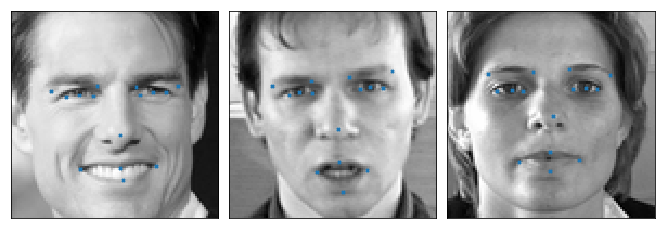

Images after Histogram Equalization


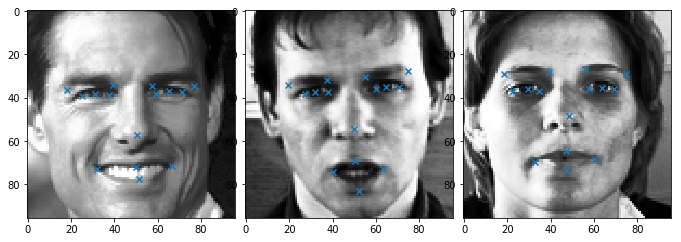

Images With Rotation


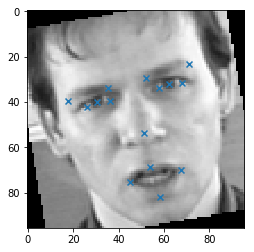

In [87]:
# Make copies of the training / validation datasets to apply augmentation
# make copies so we can apply augmentation on the copy
train2 = X_train.copy()
valid2 = X_valid.copy()
def customDataAugmentation(x):
    img = x.reshape(96,96)
    img_aug = exposure.equalize_hist(img)
    
    return img_aug

# Apply augmentation (custom) on training set
for img in range(0, 1712):
    train2[img] = customDataAugmentation(train2[img]).reshape(96,96,1)    
   
 # Apply augmentation (custom) on test set
for img in range(0, X_valid.shape[0]):
    valid2[img] = customDataAugmentation(valid2[img]).reshape(96,96,1)




def plot_img(x, y, axis):
    img = x.reshape(96,96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2], y[1::2], marker='X', s=10)
print("Images without Histogram Equalization")
# plot a few sample (un-augmented) images in gray scale from training dataset with labels
fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(1,4):
    ax = fig.add_subplot(4,5,i+1, xticks=[], yticks=[])
    plot_img(X_train[i], y_train[i], ax)
    
plt.show()
print("Images after Histogram Equalization")
# plot a few sample (augmented) images in gray scale from training dataset with labels
fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(1,4):
    plt.subplot(4, 5, i)
    plt.imshow(train2[i, :, :, 0].reshape(96,96), cmap='gray')
    plt.scatter(y_train[i, range(0,30,2)], y_train[i, range(1,30,2)], marker='x')
    
plt.show()

from scipy.ndimage import rotate
# rotate function to transform x
def rotate_X(input_X, degree):
    
    # create an array of the same size
    output_X = np.zeros((input_X.shape), dtype=np.float64)
    
    # for each image, use sklearn's rotate function to rotate image
    # this somehow changes pixel values, cap value between 0 and 255
    for i in range(output_X.shape[0]):
        output_X[i] = np.clip(rotate(input_X[i], degree, reshape=False, mode='constant'), 0, 255)  
#        output_X[i] = np.clip(rotate(input_X.reshape(-1,96,96)[i], degree, reshape=False, mode='constant', \
#                                       cval=150).reshape(96*96), 0, 255)  
    return output_X
        
    
# rotate function to transform y
def rotate_y(input_y, degree, n_point):
    
    # create an array of same size
    output_y = np.zeros((input_y.shape), dtype=np.float64)
    
    # define rotation angle and center of rotation
    theta = np.radians(degree)
    center_x = 95/2
    center_y = 95/2

    for i in range(output_y.shape[0]):
        
        # obtain x and y coordinates from dataset
        x = input_y[i][np.arange(0,n_point-1,2)]
        y = input_y[i][np.arange(1,n_point,2)]
        
        # use rotation matrix to rotate coordinates around center
        x2 = np.cos(theta) * (x - center_x) + np.sin(theta) * (y - center_y) + center_x
        y2 = -np.sin(theta) * (x - center_x) + np.cos(theta) * (y - center_y) + center_y
        
        # put x and y back in original shape
        output_y[i] = np.vstack((x2,y2)).transpose().flatten()
        
    return output_y

X_train_rotate = rotate_X(X_train, 10)
y_train_rotate = rotate_y(y_train, 10, 30)
print("Images With Rotation")

i_val=2
plt.imshow(X_train_rotate[i_val].reshape(96,96), cmap='gray')
plt.scatter(y_train_rotate[i_val, range(0,30,2)], y_train_rotate[i_val, range(1,30,2)], marker='x')


# define mirror functions
def mirror_X(input_X):
    return input_X.reshape(-1,96,96)[:, :, list(range(95, -1, -1))].reshape(-1, 96*96)
    
def mirror_y(input_y, n_point):
    output_y = input_y.copy()
    # y coordinate stays the same, x coordinate is 96-x
    output_y[:,list(range(0,n_point-1,2))] = 95 - input_y[:,list(range(0,n_point-1,2))]
    return output_y

Images With Mirroring

<img src="mirror.jpg" align="left" style="width: 250px;">

## IV: ML Approach & CNN Architectures

Our approach to the project was to build deeper understanding in Convolutional neural networks and our team experimented various architectures and hyper parameter turning approaches.  We being our discussion providing an overview of the baseline model and other key experiments we performed. Some of these architectures need GPU's to train and predict RMSE and to make this a readable summary, we summarize the model and the RMSE performance of the architectures. We initially build a function to calculate RSME's and utilize it for monitoring our algorithm progress. 


In [88]:
# RMSE
def rmse(y_true, y_pred):
    return keras.sqrt(keras.mean(keras.square(y_pred - y_true)))

# RMSE (convert back from normalized to original)
def rmse_96(y_true, y_pred):
    y_true_orig = y_true * 48 + 48
    y_pred_orig = y_pred * 48 + 48
    return keras.sqrt(keras.mean(keras.square(y_pred_orig - y_true_orig)))

# R^2
def r_squared(y_true, y_pred):
    SS_res = keras.sum(keras.square(y_true - y_pred))
    SS_tot = keras.sum(keras.square(y_true - keras.mean(y_true)))
    return (1 - SS_res / (SS_tot + keras.epsilon()))

#### IV.A Baseline Model
- We define a simple CNN model with 3 convolutional layers and utilize "RELU" activation function to compute the validation RMSE. 

In [89]:
# define simple CNN model with 3 conv layers and relu activation function
# create model
model = Sequential()
model.add(Conv2D(10, (3, 3), activation='relu', input_shape=(96,96,1), data_format='channels_last'))
model.add(Flatten())
model.add(Dense(30))


   - ##### Our baseline RMSE is 8.707
   
   <img src="BaselineResults_0.jpg" style="width: 400px;">


#### IV.B Popular Architectures Implementation
We implemented the following architectures:
 - LeNET-5
 - AlexNet
 - VGG-16
 - Adjusted VGG - 16


In [90]:
# LeNet -5 
model = Sequential()
model.add(Conv2D(6, (5, 5), strides=(1, 1), activation='relu', input_shape=(96,96,1), data_format='channels_last'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(16, (5, 5), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(120, activation='relu'))
model.add(Dense(84, activation='relu'))
model.add(Dense(30))

# AlexNet
def AlexNet(weights_path=None):
    model = Sequential()
    model.add(Conv2D(96, (11, 11), strides=(4,4), activation='relu', input_shape=(96,96,1), data_format='channels_last'))
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
    model.add(Conv2D(256, (5, 5), strides=(1,1), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
    model.add(Conv2D(384, (3, 3), strides=(1,1), padding='same', activation='relu'))
    model.add(Conv2D(384, (3, 3), strides=(1,1), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), strides=(1,1), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(2000, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2000, activation='relu'))
    model.add(Dense(30))

    if weights_path:
        model.load_weights(weights_path)

    return model
# VGG-16
def VGG_16(weights_path=None):
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(96,96,1), data_format='channels_last'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1000, activation='relu'))
    model.add(Dense(30))

    if weights_path:
        model.load_weights(weights_path)

    return model

# Adjusted VGG-16
def VGG_16_small(weights_path=None):
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(96,96,1), data_format='channels_last'))
    model.add(Conv2D(16, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(16, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(30))

    if weights_path:
        model.load_weights(weights_path)

    return model

 - The validation RMSE for these experiments generated the following results:

<img src="pop_arch.jpg" style="width: 500px;">

 - As these experiments looked promising, we proceeded to Grid Search & Rockstar Net 

#### IV.C Impact of Augmentation on RMSE 

- We defined a simple model with 3 convolution layers and 2 fully connected layers to test impact of data augmentation. We performed the following tes
<img src="dataaug.jpg" style="width: 500px;">

#### IV.D Grid Search & Rockstar Net 

- We developed multiple CNN architectures by iterating on dense layers, layer sizes, convolutional layers, We used the following parameters:

    - Number of dense layers (1 or 2)
    - Layer sizes for the convolution layer (48 or 64)
    - Number of convolution layer (1, 2 or 3)
    - Activation function: RELU
    - MaxPooling
    - Dropout = 0.3
- By building the models to the above combinations, we get to compare among 12 (2 x 2 x 3) different models run for same batch size and 20 epochs. This is to identify the top 2 best models and run them for 50 epochs to see if we are able to reduce the 'rmse' value further.

In [91]:
def iterative_search():
    # Repeat the above exercise by adding a Dropout Layer
    dense_layers=[1,2]
    layer_sizes=[48,64]
    conv_layers=[2,1]

    for dense_layer in dense_layers:
        for layer_size in layer_sizes:
            for conv_layer in conv_layers:
                NAME="Aug-{}-conv-{}-layer-{}-dense-DO-{}".format(conv_layer, layer_size, dense_layer, int(time.time()))
                print(NAME)
                       
                model = Sequential()
                model.add(BatchNormalization(input_shape=(96,96,1)))

                # Add convolutional layer with kernel size as 3, 'relu' activation and 'MaxPooling' 
                model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(96,96,1), padding="same"))
                model.add(Activation("relu"))
                model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

                for cl in range(conv_layer - 1):
                    model.add(Conv2D(filters=layer_size, kernel_size=(3,3)) )
                    model.add(Activation("relu"))
                    model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

                # Add a layer to flatten before feeding into dense layers
                model.add(Flatten())

                # Add dropout layer to address overfitting issues
                model.add(Dropout(0.3))

                for dl in range(dense_layer):
                    # Add dense layer with 100 neurons + 'relu' activation
                    model.add(Dense(200))
                    model.add(Activation("relu"))

                # Output layer for the 30 labels to be predicted
                model.add(Dense(30))

                # choose 'adam' optimizer and 'mean_squared_error' as loss function; custom metrics for evaluation
                model.compile(optimizer='adam', loss='mean_squared_error', metrics=[rmse, 'accuracy', 'mae', r_square])
            
                model.fit(X_train_combined, y_train_combined, 
                      epochs=20, batch_size=100, 
                      validation_split=0, validation_data=(X_valid, y_valid), 
                      verbose=2)
        

- The following CNN architectures  performed best in the search process:
    - 1-conv-64-layer-1-dense-DO (1 convolution layers, filter size=64, 1 dense layer (200 neurons) with Dropout (RMSE:1.71)
    - 1-conv-48-layer-1-dense-DO (1 convolution layer, filter size=48, 2 dense layer (200 neurons) with Dropout (RMSE: 1.66)
    
- Next, we use these CNN Architectures and run the models for 50 Epochs and identified "Rockstar Net" which performs best in all the experiments so far.

- Rockstar Net: 'Rockstar' neural network architecture is defined as below:

    - 1 additional Convolution Layer (layer size=48), in addition to the basic one with size=32
    - 1 Dense Layer with 200 neurons
    - Dropout Rate of 30%
    - The RSME is 1.614 in 50 epochs.

We then implement a random search scheme as explained below.

#### IV.E Random Search - 200 Architectures 

- We next proceed to test additional neural network architectures by also varying activation functions, convolutional layers & dense layers. 

In [92]:
# create model - use random search - batch 1
def create_model(x_train, y_train, n_point):

    conv_filters_S = [8, 16, 28]
    conv_filters_M = [28, 32, 64]
    conv_filters_L = [64, 96, 128]
    conv_filters_XL = [128, 256, 384]
    add_layer = ['Y', 'N']
    dense_neurons1 = [64, 96, 128, 256]
    dense_neurons2 = [32, 64, 96, 128]
    activations = ['relu', 'LeakyReLU', 'PReLU', 'randomized_relu', 'drop_activation']
    
    activation = choice(activations, p=[0.6, 0.1, 0.1, 0.1, 0.1])
    conv_filter1 = choice(conv_filters_S)
    conv_filter2 = choice(conv_filters_M)
    conv_filter3 = choice(conv_filters_L)
    conv_filter4 = 0
    conv_filter5 = 0
    
    conv_layer_4 = choice(add_layer, p=[0.6, 0.4])
    if conv_layer_4 == 'Y':
        conv_filter4 = choice(conv_filters_L)
        conv_layer_5 = choice(add_layer)
        if conv_layer_5 == 'Y':
            conv_filter5 = choice(conv_filters_XL)
            n_conv_layer = 5
        else:
            n_conv_layer = 4
    else:
        n_conv_layer = 3

        
    dense_neuron1 = choice(dense_neurons1)
    dense_neuron2 = 0
    dense_layer_2 = choice(add_layer)
    if dense_layer_2 == 'Y':
        dense_neuron2 = choice(dense_neurons2)
        n_dense_layer = 2
    else:
        n_dense_layer = 1
                
    dropout_layer = choice(add_layer, p=[0.05, 0.95])
    if dropout_layer == 'Y':
        dropout_p = uniform(0, 0.5)
    else:
        dropout_p = 0
        
    description = 'ConvLayer-{}-Filter-{}-{}-{}-{}-{}-DenseLayer-{}-Neuron-{}-{}-DropoutLayer-{:.2f}-Activation-{}'.format( \
            n_conv_layer, conv_filter1, conv_filter2, conv_filter3, conv_filter4, conv_filter5, \
            n_dense_layer, dense_neuron1, dense_neuron2, dropout_p, activation)
    
    
    # define model
    model = Sequential()
    
    # conv layer 1
    model.add(Conv2D(conv_filter1, (3, 3), strides=(1,1), padding='same', \
                     input_shape=(96,96,1), data_format='channels_last'))
    model.add(BatchNormalization())
    if activation == 'LeakyReLU':
        model.add(LeakyReLU())
    elif activation == 'PReLU':
        model.add(PReLU())
    else:
        model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
    
    # conv layer 2
    model.add(Conv2D(conv_filter2, (3, 3), strides=(1,1), padding='same'))
    model.add(BatchNormalization())
    if activation == 'LeakyReLU':
        model.add(LeakyReLU())
    elif activation == 'PReLU':
        model.add(PReLU())
    else:
        model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

    # optional conv layer 3
    model.add(Conv2D(conv_filter3, (3, 3), strides=(1,1), padding='same'))
    model.add(BatchNormalization())
    if activation == 'LeakyReLU':
        model.add(LeakyReLU())
    elif activation == 'PReLU':
        model.add(PReLU())
    else:
        model.add(Activation(activation))
    
    if conv_layer_4 == 'N':
        model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

    # optional conv layer 4
    elif conv_layer_4 == 'Y':
        model.add(Conv2D(conv_filter4, (3, 3), strides=(1,1), padding='same'))
        model.add(BatchNormalization())
        if activation == 'LeakyReLU':
            model.add(LeakyReLU())
        elif activation == 'PReLU':
            model.add(PReLU())
        else:
            model.add(Activation(activation))

        if conv_layer_5 =='N':
            model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

        # optional conv layer 5
        elif conv_layer_5 == 'Y':
            model.add(Conv2D(conv_filter5, (3, 3), strides=(1,1), padding='same'))
            model.add(BatchNormalization())
            if activation == 'LeakyReLU':
                model.add(LeakyReLU())
            elif activation == 'PReLU':
                model.add(PReLU())
            else:
                model.add(Activation(activation))
            model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

    model.add(Flatten())
    
    # fully connected layer 1
    model.add(Dense(dense_neuron1))
    if activation == 'LeakyReLU':
        model.add(LeakyReLU())
    elif activation == 'PReLU':
        model.add(PReLU())
    else:
        model.add(Activation(activation))
    
    # optional fully connected layer 2
    if dense_layer_2 == 'Y':
        model.add(Dense(dense_neuron2))
        if activation == 'LeakyReLU':
            model.add(LeakyReLU())
        elif activation == 'PReLU':
            model.add(PReLU())
        else:
            model.add(Activation(activation))
        
    # optional dropout layer before output
    if dropout_layer == 'Y':
        model.add(Dropout(rate=dropout_p))
    
    # output layer
    model.add(Dense(n_point))


    # compile model
    model.compile(loss='mean_squared_error', metrics=[rmse], optimizer='adam')

    return model, description

# create model - use random search
def create_model(x_train, y_train, n_point, activation):

    n_conv_layer = 6
    conv_filter1 = 8
    conv_filter2 = 32
    conv_filter3 = 64
    conv_filter4 = 96
    conv_filter5 = 128
    conv_filter6 = 256
    
    n_dense_layer = 3
    dense_neuron1 = 96
    dense_neuron2 = 96
    dense_neuron3 = 32
     
    description = 'ConvLayer-{}-Filter-{}-{}-{}-{}-{}-{}-DenseLayer-{}-Neuron-{}-{}-{}-Activation-{}'.format( \
            n_conv_layer, conv_filter1, conv_filter2, conv_filter3, conv_filter4, conv_filter5, conv_filter6, \
            n_dense_layer, dense_neuron1, dense_neuron2, dense_neuron3, activation)
    
    
    # define model
    model = Sequential()
    
    # conv layer 1
    model.add(Conv2D(conv_filter1, (3, 3), strides=(1,1), padding='same', \
                     input_shape=(96,96,1), data_format='channels_last'))
    model.add(BatchNormalization())
    if activation == 'LeakyReLU':
        model.add(LeakyReLU())
    elif activation == 'PReLU':
        model.add(PReLU())
    else:
        model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
    
    # conv layer 2
    model.add(Conv2D(conv_filter2, (3, 3), strides=(1,1), padding='same'))
    model.add(BatchNormalization())
    if activation == 'LeakyReLU':
        model.add(LeakyReLU())
    elif activation == 'PReLU':
        model.add(PReLU())
    else:
        model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

    # conv layer 3
    model.add(Conv2D(conv_filter3, (3, 3), strides=(1,1), padding='same'))
    model.add(BatchNormalization())
    if activation == 'LeakyReLU':
        model.add(LeakyReLU())
    elif activation == 'PReLU':
        model.add(PReLU())
    else:
        model.add(Activation(activation))
        
    # conv layer 4
    model.add(Conv2D(conv_filter4, (3, 3), strides=(1,1), padding='same'))
    model.add(BatchNormalization())
    if activation == 'LeakyReLU':
        model.add(LeakyReLU())
    elif activation == 'PReLU':
        model.add(PReLU())
    else:
        model.add(Activation(activation))
            
    # conv layer 5
    model.add(Conv2D(conv_filter5, (3, 3), strides=(1,1), padding='same'))
    model.add(BatchNormalization())
    if activation == 'LeakyReLU':
        model.add(LeakyReLU())
    elif activation == 'PReLU':
        model.add(PReLU())
    else:
        model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

    # conv layer 6
    model.add(Conv2D(conv_filter6, (3, 3), strides=(1,1), padding='same'))
    model.add(BatchNormalization())
    if activation == 'LeakyReLU':
        model.add(LeakyReLU())
    elif activation == 'PReLU':
        model.add(PReLU())
    else:
        model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
    
    
    model.add(Flatten())
    
    # fully connected layer 1
    model.add(Dense(dense_neuron1))
    if activation == 'LeakyReLU':
        model.add(LeakyReLU())
    elif activation == 'PReLU':
        model.add(PReLU())
    else:
        model.add(Activation(activation))
    
    # fully connected layer 2
    model.add(Dense(dense_neuron2))
    if activation == 'LeakyReLU':
        model.add(LeakyReLU())
    elif activation == 'PReLU':
        model.add(PReLU())
    else:
        model.add(Activation(activation))
        
    # fully connected layer 3
    model.add(Dense(dense_neuron3))
    if activation == 'LeakyReLU':
        model.add(LeakyReLU())
    elif activation == 'PReLU':
        model.add(PReLU())
    else:
        model.add(Activation(activation))    
    
    # output layer
    model.add(Dense(n_point))


    # compile model
    model.compile(loss='mean_squared_error', metrics=[rmse], optimizer='adam')

    return model, description

- We summarize the models to identify the impact of varying parameters and identify the best performing hyperparamters. The key take aways from this analysis:
    - 5 convolution layers generates the lowest RMSE 
    - 2 Dense layers generates the lowest RMSE 
    - PReLU outperforms all other activation functions 
    - Dropout of 0 - 0.3 generates the lowest RMSE 


<img src="randomsearch-ptuning.jpg" style="width: 700px;">

#### IV.E Transfer Learning 
- We run the following transfer learning models next to evaluate the impact to RMSE:
    - VGG 16 without augmentation after dropping missing values
    - VGG 16 with histogram equalization after dropping missing values
    - VGG 16 with histogram equalization and 10 degree rotation after dropping missing values
    - VGG 16 with histogram equalization and 10 degree rotation and using two models for all observations
    - Xception with histogram equalization and 10 degree rotation and using two models for all observations

In [100]:
# VGG 16 without Augmentation
class FCHeadNet:
    @staticmethod
    def build(baseModel):
        np.random.seed(666)
        # Initialize head model from pre-trained model output
        # This is basically adapted from our baseline_CNN
        # Just with an extra layer
        headModel = baseModel.output
        headModel = Flatten(name="flatten")(headModel)
        headModel = Dense(256, activation="relu")(headModel)
        #headModel = PReLU()(headModel)
        headModel = Dense(30, activation="linear")(headModel)
        
        return headModel      
# Load VGG16 network trained on ImageNet without head FC layers
baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(96, 96, 3)))

# Initialize a new head consisting of FC layers to replace VGG16's head
headModel = FCHeadNet.build(baseModel)

# Create Frankenstein (attach new FC head to VGG16 body)
model = Model(inputs=baseModel.input, outputs=headModel)

# Loop over layers from VGG model and freeze them so they don't go through
# backpropagation
for layer in baseModel.layers:
    layer.trainable = False
    # Compile our model
# Run a few epochs to warm up our new head (FC layers)
opt = Adam(lr=0.001)
model.compile(loss=rmse, optimizer=opt, metrics=[rmse, rmse_96, r_squared])
# After warming up the head FC layers, unfreeze the final set of CONV layers
# to train them
for layer in baseModel.layers[15:]:
    layer.trainable=True
    
# Recompile our model to train some of the CONV layers
opt = Adam(lr=0.001)
model.compile(loss=rmse, optimizer=opt, metrics=[rmse, rmse_96, r_squared])

# Xception with combined datasets, rotation, histogram equalization 

class FCHeadNet:
    @staticmethod
    def build(baseModel):
        np.random.seed(666)
        # Initialize head model from pre-trained model output
        # This is basically adapted from our baseline_CNN
        # Just with an extra layer
        headModel = baseModel.output
        headModel = Flatten(name="flatten")(headModel)
        headModel = Dense(256, activation="relu")(headModel)
        #headModel = PReLU()(headModel)
        headModel = Dense(8, activation="linear")(headModel)
        
        return headModel        
    
# Loop over layers from Xception model and freeze them so they don't go through
# backpropagation
for layer in baseModel.layers:
    layer.trainable = False

# Run a few epochs to warm up our new head (FC layers)
opt = Adam(lr=0.001)
model.compile(loss=rmse, optimizer=opt, metrics=[rmse, rmse_96, r_squared])
# After warming up the head FC layers, unfreeze the final set of CONV layers
# to train them
for layer in baseModel.layers[15:]:
    layer.trainable=True
    
# Recompile our model to train some of the CONV layers
opt = Adam(lr=0.001)
model.compile(loss=rmse, optimizer=opt, metrics=[rmse, rmse_96, r_squared])
# for more detailed code, please reach out to project team.

- The RMSE values of these experiments are shown below:
    
<img src="transfer1.jpg" style="width: 700px;">
<img src="transfer2.jpg" style="width: 700px;">
<img src="transfer3.jpg" style="width: 500px;">

##  V: Results & Conclusion
 

## VI: Future Enhancements 

#### 1. Development Environment
- http://jetware.io/appliances/aise/tensorflow110_keras22_python36_cuda92_notebook-180916
- https://aws.amazon.com/ec2/instance-types/p2/

#### 3. Image preprocessing
- https://keras.io/preprocessing/image/
- https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_table_of_contents_imgproc/py_table_of_contents_imgproc.html

#### 4. CNN Architectures
- http://cs231n.github.io/convolutional-networks/